# Introduction

The goal of this project was to find job postings similar to ones I was interested in and perform toic modeling. There is still plenty of work to be done and this project will be updated over the next few months. 

## About the Data: 

Listed below are the vague definitions I formulated when determining how to label the data. 

1: ML Engineer/Researcher
-  Researches, designs, implements, and monitors advanced machine learning models and systems

2: Data Scientist
- Gathers, analyzes, and interpets data through a variety of methods such as machine learning 

3: Business Intelligence Analyst
- Works with BI tools and other such as Tableau and some coding such as SQL to drive business decisions 

4: Data Analyst
- Similar role as data scientist with narrower scope (not creating predictive models)

5: Data Engineer
- Develops, tests, and maintains data pipelines as well as data architectures

6: Statistician/Statisitcal Programmer
- Leverages advanced statistics and mathematics for diagnostic, descriptive, and prescriptive analysis

7: Analyst- Other
- Analysts that do not fall into the other categories

8: Research/Academia (not in data science)
- Roles within academia or roles not related to data

9: Upper Management
- Management roles with at least 4-6 years of experience

0: None of the above
- Roles that do not fall into any of the buckets above


**Warning: DO not run the models unless you are certain the CPU/GPU/TPU can run the models without crashing**. Altering batch sizes and implementing customized multiprocessing may be neccessary depending on hardware/cloud computing constraints. 

## Dependency Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install bertopic[spacy] #for topic modeling with BERT
!pip install -U spacy #required for data preporcessing 
!pip install -U spacy[cuda113] #required if running on GPU  
!pip install -U sentence-transformers #for transforming documents
!pip install NLTK #for nlp preprocessing


In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import string
import math
import sklearn.metrics as metrics
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
# spacy.require_gpu()
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en import English
import nltk
from nltk import tokenize, sent_tokenize, word_tokenize, pos_tag
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from nltk import FreqDist
# from bertopic import BERTopic

In [ ]:
import json

In [ ]:
def down_nltk():
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('omw-1.4')
down_nltk()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Data Cleaning

In [ ]:
RANDOM_SEED = 42

In [ ]:
df= pd.read_csv("/content/drive/My Drive/job_postings.csv") #reading in file with scraped data
df_labeled = df[0:499]

In [ ]:
df = df.astype({'id':'string', 'company':'string', 'description': 'string', 'location' :'string', 'positionName': 'string'})

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_labeled, random_state = 42)

In [ ]:
roles = []
ids = ['0b3cb69b7f2722b3','00cd478b46b72485', 'b0bdb6497d255a80','227657f7f2463141']
indexes = []
cntr = 0
for id in ids:
  roles.append(df[df['id'] == ids[cntr]])
  indexes.append(df[df['id'] == ids[cntr]].index[0])
  cntr+=1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2883 non-null   string
 1   company       2883 non-null   string
 2   description   2883 non-null   string
 3   location      2882 non-null   string
 4   positionName  2882 non-null   string
dtypes: string(5)
memory usage: 112.7 KB


In [ ]:
df = df[df['location'].notna()].reset_index()

In [ ]:
df.head()

,level_0,index,id,company,description,location,positionName
0,0,0,00c7348bff0dd5db,TikTok,Responsibilities TikTok is the leading destin...,"Seattle, WA","NLP Algorithm Engineer, TikTok E-commerce Inte..."
1,1,1,00cd478b46b72485,Spectrum,Company Overview Spectrum’s Product and Te...,"Maryland Heights, MO 63043",Associate Data Scientist
2,2,2,026d27b1b19d3f9f,JDEdwardsRecruiter.com,This is an absolutely fantastic opportunity wi...,Remote,Functional JD Edwards E1 Business Analyst * Ma...
3,3,3,0284f0c17dabacf7,Merrimack College,Po...,"North Andover, MA 01845","Open Rank Ten./Tenure Track, Comp. & Data Sci"
4,4,4,028859e6ad595a61,Clearwave Fiber LLC,"Description: THIS IS A REMOTE POSITION, ...",Remote,"Analyst, Operational Reporting & Analytics"


In [ ]:
roles[0]

,id,company,description,location,positionName
24,0b3cb69b7f2722b3,WELLS FARGO BANK,"At Wells Fargo, we are looking for talented ...","Dallas, TX",2023 Wells Fargo Analytics & Data Analyst Program


In [ ]:
roles[1]

,id,company,description,location,positionName
1,00cd478b46b72485,Spectrum,Company Overview Spectrum’s Product and Te...,"Maryland Heights, MO 63043",Associate Data Scientist


In [ ]:
roles[2]

,id,company,description,location,positionName
474,b0bdb6497d255a80,Spotify,"Data, Resea...","New York, NY","Data Scientist, Messaging"


In [ ]:
roles[3]

,id,company,description,location,positionName
78,227657f7f2463141,Atlassian,Working at Atlassian At...,"Mountain View, CA","Associate Data Scientist, 2023 Graduate"


In [ ]:
X = df['description'] #descriptions for project
X_supervised_train = df_train['description']
X_supervised_test = df_test['description']

In [ ]:
import geonamescache

gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()

# gets nested dictionary for cities
cities = gc.get_cities()
def gen_dict_extract(var, key):
    if isinstance(var, dict):
        for k, v in var.items():
            if k == key:
                yield v
            if isinstance(v, (dict, list)):
                yield from gen_dict_extract(v, key)
    elif isinstance(var, list):
        for d in var:
            yield from gen_dict_extract(d, key)
cities = [*gen_dict_extract(cities, 'name')]
countries = [*gen_dict_extract(countries, 'name')]
cities = [city.lower() for city in cities]
countries = [country.lower() for country in countries]

In [ ]:
def cleaner(posting,index): #function for preprocessing all text
    posting = re.sub(df['company'][index], '', posting)
    posting = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", str(posting))
    posting = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(posting))
    posting = re.sub(r",", " , ", str(posting))
    posting = re.sub(r"!", "", str(posting))
    posting = re.sub(r"\(", " ", str(posting))
    posting = re.sub(r"\)", " ", str(posting))
    posting = re.sub(r"\?", "", str(posting))
    posting = re.sub(r"\{", " ", str(posting))
    posting = re.sub(r"\}", " ", str(posting))
    posting = re.sub(r"\[", " ", str(posting))
    posting = re.sub(r"\]", " ", str(posting))
    posting = re.sub(r"\-", "", str(posting))
    posting = re.sub(r"\_", " ", str(posting))
    posting = re.sub(r"\s{2,}", " ", str(posting))
    posting = re.sub(r"[\/,\@,\#,\?,\\,\{,\},\(,\),\[,\],\$,\%,\^,\&,\*,\<,\>]", "", str(posting))
    posting = re.sub(r'\([^)]*\)', '', str(posting))
    posting = re.sub('"','', str(posting))
    posting = re.sub(r"'s\b","",str(posting))
    posting = re.sub(r"\s+"," ",str(posting))
    posting = re.sub("[^a-zA-Z0-9]", " ", str(posting))
    posting = re.sub(r"\b\d+\b", "", str(posting)) 
    # posting = re.sub(r"\b[^ai\b", "", posting)
    return posting


In [ ]:
def get_capital_words(posting):
  words = re.findall(r'\b[A-Z].*?\b', posting) 
  words = [word.lower() for word in words] #since we are focusing on skills, we will extract capital words only (will make model easier to extract insights from )def
  return words

In [ ]:
unigrams_df = pd.read_csv("/content/drive/MyDrive/Job_Search_Opitmizer_Docs/count_unigrams.txt", sep = "\t", names = ["Word", "Count"])

In [ ]:
stop_words = unigrams_df[unigrams_df['Count'] >= 30000000]['Word'].to_list() #common words to remove form possible skills

In [ ]:
words_to_remove = ['Position',
 'Overview','Company', 'JOB','SUMMARY','RESPONSIBILITIES','REQUIRED',
 'QUALIFICATIONS', 'Skills','Responsible', 'Ability'
 'Abilities','Experience','Minimum','Background', 'Backgrounds', 'Opportunity','Position',
 'Description', 'qualification', 'Experiences', 'Opportunities']

In [ ]:
removed_words = [word.lower() for word in words_to_remove]

In [ ]:
stop_words += removed_words + cities + countries

In [ ]:
def cleaning(doc):
    # Lemmatizes and removes stopwords, doc needs to be a spacy 'doc'
    txt = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    return ' '.join(txt)

In [ ]:
for word, i in zip(removed_words,range(len(removed_words))):
  print(word, i)

position 0
overview 1
company 2
job 3
summary 4
responsibilities 5
required 6
qualifications 7
skills 8
responsible 9
abilityabilities 10
experience 11
minimum 12
background 13
backgrounds 14
opportunity 15
position 16
description 17
qualification 18
experiences 19
opportunities 20


In [ ]:
cleaner_postings =  [cleaner(posting,i) for posting,i in zip(X, range(len(X)))]
words_capital = [get_capital_words(posting) for posting in cleaner_postings]
cleaner_postings = [posting.strip().lower() for posting in cleaner_postings]
# cleaner_train =  [cleaner(posting) for posting in X_supervised_train]
# cleaner_test = [cleaner(posting) for posting in X_supervised_test]

In [ ]:
words_capital[0][0:10]

['responsibilities',
 'our',
 'los',
 'angeles',
 'new',
 'york',
 'london',
 'paris',
 'berlin',
 'dubai']

In [ ]:
word_capital =[" ".join(post_capital_words) for post_capital_words in words_capital]

In [ ]:
word_capital[0]

'responsibilities our los angeles new york london paris berlin dubai mumbai singapore jakarta seoul tokyo why join us at we we here join our nlp ml e platform more intelligent customer service product knowledge graphs what participate ai participate collaborate responsibilities build language faq develop knowledge spu construct qualifications minimum qualifications minimum qualifications bachelor computer science nlp experience c python go java good preferred qualifications proficient tensorflow pytorch experience aware familiar dnn lstm cnn lda word2vec elmo gpt bert experience such hadoop spark hive flink our at to we if'

In [ ]:
lem_words = [cleaning(doc) for doc in nlp.pipe(word_capital, batch_size=100)] 
# lem_train = [cleaning(doc) for doc in nlp.pipe(cleaner_train, batch_size=100)]
# lem_test = [cleaning(doc) for doc in nlp.pipe(cleaner_test, batch_size=100)]

In [ ]:
lem_words[0]

'responsibilitie berlin dubai mumbai singapore jakarta seoul tokyo nlp ml intelligent graph participate ai participate collaborate spu construct bachelor nlp python preferred proficient tensorflow pytorch aware familiar dnn lstm cnn lda word2vec elmo gpt bert hadoop spark hive flink'

In [ ]:
lem_words[1]

'wifi charter scientist actively participate leverage assist observe establish assist achieve tableau tableau qualification skill minimal minimal python sql willingness bachelor analytic prefer relate internship bda302'

In [ ]:
lem_words = [re.sub('datum','', post) for post in lem_words] #fixing weird conversion when switching to spacy doc

# lem_train = [re.sub('datum','', post) for post in lem_train]
# lem_test = [re.sub('datum','', post) for post in lem_test]

In [ ]:

cleaned_words = pd.Series(lem_words).dropna().tolist()
# cleaned_train = pd.Series(lem_train).dropna().tolist()
# cleaned_test = pd.Series(lem_test).dropna().tolist() 

In [ ]:
cleaned_words[3]

'artificial cybersecurity  cads artificial cybersecurity supervise establish contribute merrimack cultivate merrimack cad cad bs bs cads additionally candidate ph  demonstrate commitment possess additionally merrimack engineer stem innovation subsequent catholic augustinian resume curriculum vitae vaccination merrimack covid vaccination covid catholic augustinian catholic augustinian merrimack catholic augustinian catholic augustinian catholic augustinian merrimack winston girard andover andover merrimack m1 carnegie classification institution merrimack merrimack merrimack ncaa I employer'

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def top_n_similarities(n, num_postings, all_postings, interested_post_index, main_df): #parameters are number of similar postings, number of postings to choose from,
  # pandas dataframe of job_postings, index of job posting of interest, and original dataframe
  tfidf = TfidfVectorizer() 
  transformed = tfidf.fit_transform(cleaned_postings) #vectorizing data
  max_sims = [0 for i in range(n)] #number of similarities
  ind = [None for i in range(n)]
  curr_comps = [None for i in range(n)] #indices of similar porings
  counter = 0
  for i in range(num_postings):
    sim = cosine_similarity(transformed[interested_post_index], transformed[i]) #getting similarities
    comp1 = main_df['company'][interested_post_index].lower()
    try:
      comp2 = main_df['company'][i].lower()
    except:
      print('oops', ' ', i )
    if comp1 not in comp2  and comp2 not in comp1: #making sure the same companies aren't selected
      if counter < n: #if one of the first n postings
          max_sims[counter] = sim
          ind[counter] = i 
          counter += 1
      #if similarity is higher than any of the current top 5 similar postings and company is not in top n similar
      elif sim > min(max_sims) and comp2 not in curr_comps: 
        index_replaced = max_sims.index(min(max_sims)) #finding index to replace
        max_sims[index_replaced] = sim #replace score
        ind[index_replaced] = i #replacing index from job_post dataa=frame
        curr_comps[index_replaced] = comp2
  return max_sims, ind #returns top n similar job postings and the original index
arr1, ind1 = top_n_similarities(3, len(cleaned_postings), cleaned_postings, indexes[0], df)
  

In [ ]:
arr2, ind2 = top_n_similarities(3, len(cleaned_postings), cleaned_postings, indexes[1],df)

In [ ]:
arr3, ind3 = top_n_similarities(3, len(cleaned_postings), cleaned_postings, indexes[2],df)

In [ ]:
arr4, ind4 = top_n_similarities(3, len(cleaned_postings), cleaned_postings, indexes[3],df)

Below I took the 5 most similar roles for each of the 3 job postings from above. As can be seen some of the job postings are nearly idenitcal (besides location). 

In [ ]:
arr_f = np.array([ind1,ind2,ind3,ind4]).flatten()
arr_f
df.iloc[arr_f].head(15)

,id,company,description,location,positionName
80,236ea975b65a9288,TEKsystems,Equivalent Experience Description: The ...,"Chicago, IL 60601",Data Analyst
1770,6feff3c791fe08bd,U.S. Bank,"At U.S. Bank, we're passionate about helping...","Minneapolis, MN",HR Data Analyst
2438,6677ddf3737fd3d5,Retool,Team Data Science & Analytics L...,"San Francisco, CA",Data Scientist
1932,ae925abd90289edf,Home Depot / THD,Position Purpose: The Associate Data S...,"Atlanta, GA 30301","Associate Data Scientist, Decision Analytics"
1720,5ec59cbdbacb4931,Gainwell Technologies,Job Description: Essential Job Functions ...,"Roseville, CA 95661",Associate Professional Business Analyst
2708,c1d100eaadd1adf2,Vaco,Position Purpose: The Data Scientist is re...,"Atlanta, GA",Data Scientist (Remote)- $120k-$130k
584,d3cf733e01efcf96,Winter Park Resort,"Please note, this position is located at Win...","Fort Collins, CO 80523",Marketing Analytics & Insights Senior Analyst ...
2446,694c719397383ca3,Mfour Mobile Research Inc,"Data Analyst MFour Mobile Research, Inc. I...",United States,Data Analyst
497,b8b5d5f0b2ebb247,Recruiting From Scratch,Who is Recruiting from Scratch: Recruit...,"Los Angeles, CA 90210",Otter AI | NLP Engineer
1985,c6da9104607b15c3,Ipsos North America,Data Scientist Division: Global Science O...,"Culver City, CA",Data Scientist


## With Transformers

### Document Similairty

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np

In [ ]:
model = CrossEncoder('cross-encoder/stsb-distilroberta-base')

KeyboardInterrupt: ignored

In [ ]:
target_post = cleaned_words[2450]
sentence_combinations = [[target_post, posting] for posting in cleaned_words]
similarity_scores = model.predict(sentence_combinations)



In [ ]:
sim_scores_argsort = (np.argsort(similarity_scores)[::-1][0:10])

print("Top 5 Scores")
for idx in sim_scores_argsort:
    print(f"Similarity: {similarity_scores[idx]}, {idx}")

Top 5 Scores
Similarity: 0.9394735097885132, 2450
Similarity: 0.8768051862716675, 1662
Similarity: 0.8210473656654358, 1806
Similarity: 0.8189841508865356, 1255
Similarity: 0.8186459541320801, 426
Similarity: 0.778357207775116, 2780
Similarity: 0.7771926522254944, 2072
Similarity: 0.7614189982414246, 2848
Similarity: 0.7605374455451965, 2086
Similarity: 0.7592994570732117, 425


In [ ]:
df.iloc[sim_scores_argsort].head(10)

,level_0,index,id,company,description,location,positionName
2450,2450,2451,6ac50f4702b24459,PNC Financial Services Group,"Position Overview At PNC, our people are ...","Pittsburgh, PA",Data Analytics Development Program Analyst/Ass...
1662,1662,1662,4aaab6417616eb91,Savings Bank of Mendocino County,JOB DESCRIPTION Job Title: Business System...,"Ukiah, CA 95482",Business Systems Analyst
1806,1806,1806,7ded37f0b4c167e7,US Department of Energy - Agency Wide,Duties This series covers posit...,"Idaho Falls, ID",Data Scientist
1255,1255,1255,bc25aba6e6e86d68,Medical College of Wisconsin,Business Intelligence Statistical Analyst’ ...,"Milwaukee, WI 53226",Business Intelligence Statistical Analyst’
426,426,426,a235105419af586e,US Department of Energy - Agency Wide,Duties This series covers posit...,"Wallops Island, VA",Data Scientist
2780,2780,2781,dd9bff9a92c0f004,Philips,"Job Title Data Analyst, Complaint Management...","Cambridge, MA 02141","Data Analyst, Complaint Management"
2072,2072,2072,e444e686222db7b7,Fanatics Inc.,Company Overview Fan...,"San Mateo, CA",Data Privacy Analyst
2848,2848,2849,f353711062e84208,US Office of Personnel Management,Duties THIS IS A PUBLIC NOTICE: This N...,"Albuquerque, NM",Data Scientist
2086,2086,2086,e7e719f1f568ea17,Terumo Medical Corporation,Terumo Medical Corporation (TMC) deve...,"Somerset, NJ",Senior Data Analytics Specialist
425,425,425,a221a4559ab9d3ae,California Public Utilities Commission,...,"Sacramento County, CA",FISCAL ANALYST


In [ ]:
print(ind3) #5 most similar from cosine similarity with data preporcessing

[584, 2445, 497]


There is a large variation between the document similarity outputs when using the cross encoder versus data preprocessing with cossine similarity and TFIDF. There is no way of measuring which solution is better without the target variable to it is left to user disccretion which one is preferred (if goal is stil job optimization). 

### Topic Modeling

Greate article for helping with topic modeling BERT:
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
!pip install bertopic
!pip install --upgrade joblib==1.1.0 #must use older version to fix dependency issue with HDBSCAN
from bertopic import BERTopic

I chose to remove the words below because they are either words for the header, vague, or don't relate to the job at all. For example, Qualification is probably a header, demonstrte is very vague, and dental likely refers to the benefits package. 

In [ ]:
!pip install geonamescache

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.4 MB 2.7 kB/s 


In [ ]:
word_removal = ['data','skill','requirement','candidate','disability','relate','insight','gender','qualification','stakeholder',
 'diverse','diversity','demonstrate','familiarity', 'preferred', 'conduct','bachelor', 'employer','dental', 'familiarity', 'salary', 
 'reliably','prefer','proficiency', 'memorial','verification','talent','flexible', 'analyze', 'assist','collaborate','analytic','analytical','analyst', 'aota', 
 'hawai', 'covid', 'xometry', 'usajob', 'usa', 'ef', 'sf','proficient', 'foxtrot','cmb', 'nielseniq','walgreen','phd'] 


In [ ]:
for i in range(len(cleaned_words)):
  temp = []
  for word in word_tokenize(cleaned_words[i]):
    if word not in word_removal:
      temp.append(word)
  cleaned_words[i] = " ".join(temp)

In [ ]:
cleaned_words[0]

'responsibilitie berlin dubai mumbai singapore jakarta seoul tokyo nlp ml intelligent graph participate ai participate spu construct nlp python tensorflow pytorch aware familiar dnn lstm cnn lda word2vec elmo gpt bert hadoop spark hive flink'

### First Model and Visualization Walk through

In [ ]:
from bertopic import BERTopic
from transformers.pipelines import pipeline
embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
topic_model = BERTopic(embedding_model=embedding_model, top_n_words=10, diversity = 0.1) #diversity score calculated t for non-diverse words
topics, probs = topic_model.fit_transform(cleaned_words[0:1000])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
topic_model.get_topic(0)

[('sql', 0.029019618000261756),
 ('dis', 0.028849722157235864),
 ('durham', 0.027973070028414832),
 ('python', 0.021795813566449506),
 ('agile', 0.019989837762459852),
 ('roi', 0.018861514944723524),
 ('pangle', 0.018784713865636904),
 ('kpis', 0.01835182517182756),
 ('dutie', 0.0177615045745281),
 ('singapore', 0.01730983329434152)]

This is very challenging to read so we will try two more topic modeling/ clustering techniques. 

In [ ]:
topic_model.visualize_documents(cleaned_words[0:1000])

Stop words clearly need to be removed since they do not provide much value for isolating the different documents.

### Second Model and Visualization Walkthrough

I need to reduce the dimensionality of the data so the distance metrics with DBSCAN will be effective. 

In [ ]:

from umap import UMAP
posts = cleaned_words[0:1000]
sentence_model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = sentence_model.encode(posts, show_progress_bar=True)



Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
umap_embeddings = UMAP(n_neighbors=15, 
                            n_components=2, #needs to be 2 for graph to work 
                            metric='cosine').fit_transform(embeddings)

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
HDBSCAN is less sensitive to noise than DBSCAN so we will using this clustering algorithm instead. Above is the documentation which i found helpful. 

I used 'leaf' for clustering selection method instead of 'eom' to allow for more clusters. I then fined tuned other paramaters such as min_cluster size to help increase cluster density. Also HDBSCAN allows for values to be outlier and as a result not all postings need to be assigned to a cluster (as can be seen in the graph below). 

In [ ]:
from hdbscan import HDBSCAN
cluster = HDBSCAN(min_cluster_size=40, 
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(umap_embeddings)

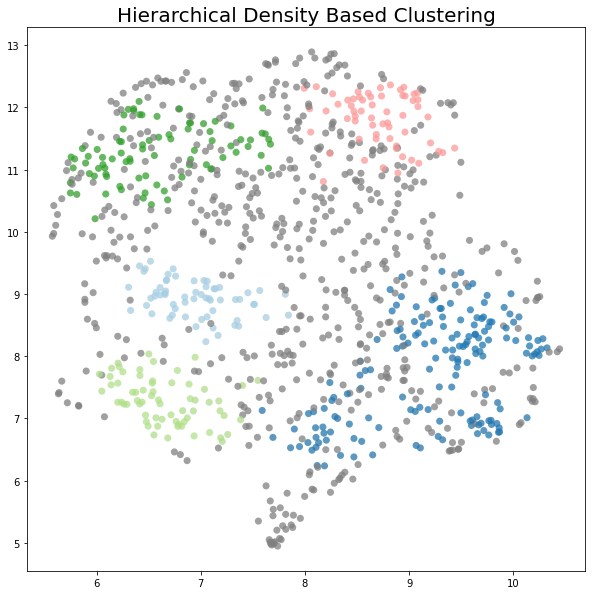

In [ ]:
import seaborn as sns
color_palette = sns.color_palette('Paired', 100) #add more colors to prevent index error in next steps 
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in cluster.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, cluster.probabilities_)]
plt.scatter(*umap_embeddings.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.75)
plt.title("Hierarchical Density Based Clustering")
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(stop_words = 'english')
embeddings = sentence_model.encode(posts, show_progress_bar=False)
bert1 = BERTopic(hdbscan_model = cluster, language = "english", vectorizer_model = vectorizer)

In [ ]:
topics, probs = bert1.fit_transform(posts,embeddings)

In [ ]:
bert1.get_topic_info().head(5)

,Topic,Count,Name
0,-1,595,-1_analyst_sql_excel_python
1,0,158,0_analyst_gs_veteran_usajob
2,1,69,1_python_fis_sql_ml
3,2,67,2_analyst_excel_cmb_aota
4,3,56,3_sql_analyst_xometry_bi


In [ ]:
bert1.visualize_heatmap()

The similarity matrix shows the most commonality between topic 0 and 2. This is likely due to the fact they both appear to be generic analyst roles. 

In [ ]:
bert1.visualize_barchart()

Topic 0 seems to be a general analyst role.

Topic 1 appears to be what most people would refer to as a data scientist.

Topic 2 appeares to be a dats analyst role. 

Topic 3 appears to be a Bunisness Intelligence Role. 

Topic 4 appears to an AI research role.


Here is a great link that helped with understanding UMAP:
https://umap-learn.readthedocs.io/en/latest/parameters.html


# Supervised Learning With Labeld Data

In [ ]:
df_train

,id,company,description,location,positionName,Manual_Label
46,1765fcb38f2aa674,Allworth Financial,\n \n Allworth Financial (www.allworthfinanci...,"Cincinnati, OH 45249",Operations Data Analyst,4.0
31,0f523e00cd9a18df,Apple,\n \n \n \n Summary \n \n \n ...,"Austin, TX",Technical Program Manager - Data Science and A...,9.0
113,3066458351ac4b67,Securian Financial Group,\n \n Securian Financial Groups internal posi...,"Saint Paul, MN 55101",Data Science Consultant,2.0
334,7a59b2b6a1d4e67c,ENGIE North America Inc.,\n\n \n ENGIE Power & Gas LLC provides Gas an...,"Detroit, MI",IT Data Analyst I,4.0
274,6707f1d50b3be666,Solera,\n \n Job Title/Location\n \n \n \n Who We ...,Remote,Data Scientist / Deep Learning Engineer,2.0
...,...,...,...,...,...,...
106,2db14cca6900c346,KlearNow,"\n \n Be a part of a rapidly growing, \n ser...",California,AI/ML Engineer,1.0
270,65cf3622c825988f,Turing Talent,About Turing Talent\nThe Turing Talent Program...,"New York, NY 10016",VP Machine Learning at Kunato (with Turing Tal...,9.0
348,80f448ce7d5d691c,"HR Unlimited, Inc.",HR Unlimited Inc. is a premier consulting firm...,"Santa Ana, CA 92705",HR Data Analyst,4.0
435,a6aa66279b9266f4,Kani Solutions,Job Description: -\nDesign and Develop\nRespon...,Remote,Data Scientist,2.0


# Conclusion

I was extremely naive with my initial scope of the project. Trying to create method to accurately classify new job postings was insane. I probably spent 50+ hours before giving up on this. After giving up, I tried to just classify on labels I created myself. I once again spent hours longer tring to do this. I tried reducing the scope again to gain a good sihloutte score for topic modeling. Unfortunately, I did not have the knowledge within NLP to do the data preprocessing. Even are receiving assistance, I realized clustering documents of the size I was working with was unrealistic. I tried using HuggingFace to help with implementation with new project ideas such as using zero-shot classification. However, the run time was way to slow.

Prior to all of this taking place, I got a 14-day free trial to datbricks to try learning a new tool and gain exposure to data engineering. I however failed with this as well by pricing out of the AWS free tier.

Clustering was unsuccessful as well after many hours and I resorted to just a table of similarity metrics with 10 randomly selected documents.

There were many more failures throughout the duration of the project but I learned a very important lesson to be okay with imperfection. In the near future I will have a more detailed discussions,preprocessing, and modeling.

I was very happy to atleast be able to graph some  noticebale differences between some of the documents with HDBSCAN. I was unfamiliar with this technique before the assignment. I was also surprised how easy the concepts of transformers, encoders, and other new concepts were to pick up. I hope to expand on this knowledge in the near future. 

## Redfining Scope:
The original goal was to create production ready code from webscraping Data to having a web app that user could find a list of relevant roles based on their interests. The scope of the project was redefined due to the following limitations.

#### Limitiation 1 :
    
Inability to gain access to an API or access to webscrape. Websites that jost job postings such as Indeed and LinkedIn have made it difficult to extract information from their website. Also, most APIs are geared towards companies wanting to post job roles and not for potential applicants wanting to gain access to the job postings.
    
#### Solution 1 :
    
Used a third party tool that performed the webscraping and webcrwaling. As a result of doing this, you will have to find a way to extract information for your own database. This project only works given you have the database as a CSV file already. 

#### Limitiation 2:

Formulating a supervised learning approach. I had attempted to create an ontology that would allow me to assign labels to specific job roles (target variable).         However, there was clear personal bias with this approach. On top of this the only way to train the model would have been to inidividually label whether a posting     belonged to the right title, a tedious task when working with thousands of different postings.  
    
#### Solution 2:
    
I decided to find "similiar" job postings to the ones I had interest in instead. 

#### Limitiation 3:

I only had a 14 day subscription to databricks and placed out of the AWS free tier within a week.

#### Solution 3:
Keeping data engineering and ML engineering aspects of the project to a minimum. 
